In [1]:
import json
# Load imagenet label
labels = []
with open("/home/junda/fastdir/lily/CopyRightErase/Erasing-Concepts-In-Diffusion/resnet_label.json") as f:
    labels = json.load(f)
car_related_labels = ['taxicab', 'race car', 'passenger car', 'convertible','station wagon', 'pickup truck', 'grille', 'sports car', 'car wheel','minivan', 'jeep','tow truck', 'freight car', 'tow truck']
car_indices = [labels.index(label) for label in car_related_labels]    

In [2]:
target_index = labels.index("French horn")

In [3]:
import torch
from torchvision import transforms
from PIL import Image
# Load Resnet50 weights
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import functional as F

# fine_tune_path = "/home/junda/fastdir/lily/CopyRightErase/Erasing-Concepts-In-Diffusion/finetuned_images_cars/car_0.finetuned.png"
# orig_path = "/home/junda/fastdir/lily/CopyRightErase/Erasing-Concepts-In-Diffusion/finetuned_images_cars/car_0.original.png"

# Load pre-trained ResNet-50 model
resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
resnet50.eval()  # Set the model to evaluation mode

# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


/home/junda/miniconda3/envs/sd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def compute_prob_from_output(output):
    car_weight = output[0][car_indices]
    # print(car_weight)
    print("Target: ", labels[torch.argmax(output[0])])
    return torch.logsumexp(car_weight, 0) - torch.logsumexp(output[0], 0)
    # return torch.logsumexp(car_weight, 0)
    # return output[0][target_index]

In [5]:
from StableDiffuser import StableDiffuser
from finetuning import FineTunedModel
import torch
from tqdm import tqdm
import datetime
import torchvision
import torchvision.transforms as T
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from PIL import Image
from diffusers import AutoencoderKL

In [6]:
# mean_resnet = np.array([0.485, 0.456, 0.406])
# std_resnet = np.array([0.229, 0.224, 0.225])
# val_transform = T.Compose([
#     T.Resize((256, 256)),
#     T.CenterCrop(224),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# def rgb(input):
#     input = (input/2 + 0.5)
#     MAX = torch.max(input).detach()
#     MIN = torch.min(input.detach())
#     input = (input - MIN) / (MAX - MIN)
#     input = val_transform(input)
#     print(input.shape)
#     # input = input.permute(0, 2, 3, 1)
#     # input = (input * 255).round().astype("uint8")
#     tmp = torch.zeros((1, 512, 512, 3))
#     tmp[0, :, :, 0] = input[0, 0, :, :]
#     tmp[0, :, :, 1] = input[0, 1, :, :]
#     tmp[0, :, :, 2] = input[0, 2, :, :]
#     return val_transform(tmp[0])

In [7]:
# x = torch.randn(1,3,512,512)

In [8]:

class RGBConverter(nn.Module):
    def __init__(self):
        super(RGBConverter, self).__init__()
        # Magic number used in the detector
        mean_resnet = np.array([0.485, 0.456, 0.406])
        std_resnet = np.array([0.229, 0.224, 0.225])
        self.val_transform = T.Compose([T.Resize((256, 256)),T.CenterCrop(224),T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    def toRGB(self, RGBA, background=(255,255,255)):
        # _, D, R, C = RGBA.shape
        # if D == 3:
        #     return RGBA
        # RGB = torch.zeros((1, 3, R, C), dtype=torch.float32)
        # R, G, B, A = RGBA[0].split(1, dim=0)
        # A = A.float() / 255
        # RGB[0, 0,:,:] = R.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[0]
        # RGB[0, 1,:,:] = G.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[1]
        # RGB[0, 2,:,:] = B.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[2]
        return RGB

    def forward(self, input):
        # input = (input/2 + 0.5)
        MAX = torch.max(input).detach()
        MIN = torch.min(input).detach()
        input = (input - MIN) / (MAX - MIN)
        # input = input.permute(0, 2, 3, 1)
        # input = (input * 255).round().astype("uint8")
        # tmp = torch.zeros((1, 512, 512, 3))
        # tmp[0, :, :, 0] = input[0, 0, :, :]
        # tmp[0, :, :, 1] = input[0, 1, :, :]
        # tmp[0, :, :, 2] = input[0, 2, :, :]
        return self.val_transform(input)

In [9]:
import torch.optim as optim

class CarModel(nn.Module):

    def __init__(self):
        super(CarModel, self).__init__()
        self.rgb = RGBConverter()
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda:1")
        self.vae.eval()
        self.classifier = resnet50
        for param in self.classifier.parameters():
            param.requires_grad = False   

    def forward(self, x):
        x = self.vae.decode(1 / self.vae.config.scaling_factor * x).sample
        x = self.rgb(x)
        x = self.classifier(x)
        # print(x.shape)
        # x = F.softmax(x, dim=1)
        # total_probability = 0
        # for i in car_indices:
        #     total_probability -= x[0][i]
        # x =torch.sigmoid(total_probability)
        # print(total_probability)
        # return total_probability
        return x

class ObjectDetector():
    def __init__(self):
        self.dtype = torch.FloatTensor
        if (torch.cuda.is_available()):
            self.dtype = torch.cuda.FloatTensor
        # transfer learning on top of ResNet (only replacing final FC layer)
        self.model = CarModel()
        
        self.model.to("cuda:1")
        self.device = "cuda:1"
        # self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def get_input_grad(self, x): 
        x_var = Variable(x.type(self.dtype).to(self.device), requires_grad=True)
        resnet_output = self.model(x_var)
        prob = compute_prob_from_output(resnet_output)
        print(f"Car Probability: {prob}")
        prob.backward()
        return x_var.grad
        

In [10]:
prompt="car"
modules = "unet$"
iterations=150
negative_guidance=1
lr=0.015
save_path="./experiment_car/car"
freeze_modules=[]

In [11]:
# kwargs = dict(locals())
# print(f"train kwargs: {kwargs}")
print("BEGIN TRAIN")  
nsteps = 50

diffuser = StableDiffuser(scheduler='DDIM').to('cuda:1')
diffuser.train()


# finetuner = FineTunedModel(diffuser, modules, frozen_modules=freeze_modules)
finetuner = FineTunedModel.from_checkpoint(diffuser, "models/vangogh.pt")

params = list(finetuner.parameters())
criteria = torch.nn.MSELoss()

print("Begin pbar")
pbar = tqdm(range(iterations))

with torch.no_grad():
    # neutral_text_embeddings = diffuser.get_text_embeddings([''],n_imgs=1)
    positive_text_embeddings = diffuser.get_text_embeddings([prompt],n_imgs=1)

# del diffuser.vae
# del diffuser.text_encoder
# del diffuser.tokenizer
del diffuser.safety_checker

torch.cuda.empty_cache()

BEGIN TRAIN


/home/junda/miniconda3/envs/sd/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


=> Finetuning unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.0.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.1.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.1.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.2.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.2.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.2.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.2.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.3.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.3.attentions.1.transformer_blocks.0.

  0%|          | 0/150 [00:00<?, ?it/s]

In [12]:
# finetuner = FineTunedModel(diffuser, modules, frozen_modules=freeze_modules)
# params = list(finetuner.parameters())
# optimizer = torch.optim.SGD(params, lr=lr)

In [13]:
# optimizer = torch.optim.SGD(params, lr=lr)

In [14]:
# del detector, optimizer
detector = ObjectDetector()
optimizer = torch.optim.SGD(params, lr=lr)


In [15]:
!rm -r experiment_car
!mkdir experiment_car

In [16]:
# generated_images = []
for i in pbar:
    with torch.no_grad():
        diffuser.set_scheduler_timesteps(50)

        optimizer.zero_grad()

        diffuse_iter = torch.randint(40, nsteps-1, (1,)).item()
        print("Diffuser Iteration: ", diffuse_iter)
        # diffuse_iter = nsteps-1

        latents = diffuser.get_initial_latents(1, 512, 1)
        # print("LATENT SIZE: ", latents.size())
        with finetuner:
            latents_steps, _ = diffuser.diffusion(
                latents,
                positive_text_embeddings,
                start_iteration=0,
                end_iteration=diffuse_iter,
                guidance_scale=3,
                show_progress=False,
            )
        
        # diffuser.set_scheduler_timesteps(diffuse_iter+1)
        # diffuse_iter = int(diffuse_iter / nsteps * 1000)
        # ref_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], positive_text_embeddings, guidance_scale=1)
        with finetuner:
            ref_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], positive_text_embeddings, guidance_scale=1)


    with finetuner:
        negative_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], positive_text_embeddings, guidance_scale=7)
    
    # y = torch.tensor([53]) # label of Von Gogh
    
    # dump input_x to a file
    # torch.save(input_x, "detector/artist/test_vg/input_{}.pt".format(i))
    # generated_images.append(input_x)
    
    # print(torch.norm(detector_grad))
    # print(torch.norm(neutral_latents))
    # print(torch.norm(negative_latents))
    input_x = latents_steps[0]    
    detector_grad = detector.get_input_grad(input_x)        
    loss = criteria(negative_latents.float(), ref_latents.detach().float() + 40*(detector_grad)) #loss = criteria(e_n, e_0) works the best try 5000 epochs
    print(f"Detector Gradient:{torch.norm(detector_grad)}")
    print(f"Noise Gradient:{torch.norm(ref_latents)}")    
    loss.backward()
    print("Loss function")
    print(loss.item())
    print("Gradient Scale")
    gradient = params[0].grad
    print(torch.norm(gradient))        
    optimizer.step()
    print("end")


    if i % 10 == 0 and i != 0:
        now_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        torch.save(
            finetuner.state_dict(), 
            save_path + f'_checkpoint_{i}_{now_str}.pt'
        )

now_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(finetuner.state_dict(), save_path + f'_{now_str}.pt')



torch.cuda.empty_cache()

Diffuser Iteration:  47


/mnt/ssd2/junda/lily/CopyRightErase/Erasing-Concepts-In-Diffusion/StableDiffuser.py:75: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, self.unet.in_channels, img_size // 8, img_size // 8),
/home/junda/miniconda3/envs/sd/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are u

Target:  convertible
Car Probability: -0.7408556938171387
Detector Gradient:1.4566292762756348
Noise Gradient:76.34839630126953
Loss function
0.21017391979694366
Gradient Scale


  1%|          | 1/150 [00:09<24:33,  9.89s/it]

tensor(0.0047, device='cuda:1')
end
Diffuser Iteration:  48
Target:  station wagon
Car Probability: -0.6740927696228027
Detector Gradient:1.7758079767227173
Noise Gradient:67.67221069335938


  1%|▏         | 2/150 [00:16<20:05,  8.14s/it]

Loss function
0.3087637424468994
Gradient Scale
tensor(0.0056, device='cuda:1')
end
Diffuser Iteration:  46
Target:  jeep
Car Probability: -1.980119228363037
Detector Gradient:7.030463218688965
Noise Gradient:79.5383529663086


  2%|▏         | 3/150 [00:23<18:17,  7.47s/it]

Loss function
4.825788497924805
Gradient Scale
tensor(0.0174, device='cuda:1')
end
Diffuser Iteration:  42
Target:  station wagon
Car Probability: -0.9152770042419434
Detector Gradient:2.7547788619995117
Noise Gradient:102.43663024902344


  3%|▎         | 4/150 [00:29<16:53,  6.94s/it]

Loss function
0.7440646886825562
Gradient Scale
tensor(0.0050, device='cuda:1')
end
Diffuser Iteration:  45
Target:  station wagon
Car Probability: -1.209974765777588
Detector Gradient:5.141167640686035
Noise Gradient:87.7470703125


  3%|▎         | 5/150 [00:36<16:25,  6.79s/it]

Loss function
2.5825841426849365
Gradient Scale
tensor(0.0308, device='cuda:1')
end
Diffuser Iteration:  45
Target:  jeep
Car Probability: -0.9381251335144043
Detector Gradient:4.788506507873535
Noise Gradient:89.22640228271484


  4%|▍         | 6/150 [00:42<16:05,  6.71s/it]

Loss function
2.2435336112976074
Gradient Scale
tensor(0.0106, device='cuda:1')
end
Diffuser Iteration:  41
Target:  station wagon
Car Probability: -1.1258549690246582
Detector Gradient:1.3095585107803345
Noise Gradient:104.97575378417969


  5%|▍         | 7/150 [00:48<15:27,  6.48s/it]

Loss function
0.17191359400749207
Gradient Scale
tensor(0.0032, device='cuda:1')
end
Diffuser Iteration:  40
Target:  grille
Car Probability: -1.5416760444641113
Detector Gradient:4.293728828430176
Noise Gradient:108.72876739501953


  5%|▌         | 8/150 [00:54<14:54,  6.30s/it]

Loss function
1.8069406747817993
Gradient Scale
tensor(0.0095, device='cuda:1')
end
Diffuser Iteration:  47
Target:  station wagon
Car Probability: -0.6497159004211426
Detector Gradient:1.6843990087509155
Noise Gradient:83.94259643554688


  6%|▌         | 9/150 [01:01<15:11,  6.46s/it]

Loss function
0.27945518493652344
Gradient Scale
tensor(0.0031, device='cuda:1')
end
Diffuser Iteration:  47
Target:  station wagon
Car Probability: -0.8073639869689941
Detector Gradient:1.3874512910842896
Noise Gradient:89.3345947265625


  7%|▋         | 10/150 [01:08<15:21,  6.58s/it]

Loss function
0.19116710126399994
Gradient Scale
tensor(0.0036, device='cuda:1')
end
Diffuser Iteration:  48
Target:  grille
Car Probability: -0.8015804290771484
Detector Gradient:1.3307517766952515
Noise Gradient:67.72128295898438
Loss function
0.17690829932689667
Gradient Scale
tensor(0.0053, device='cuda:1')
end


  7%|▋         | 11/150 [01:15<15:40,  6.76s/it]

Diffuser Iteration:  46
Target:  minivan
Car Probability: -0.6262397766113281
Detector Gradient:1.8423056602478027
Noise Gradient:96.70832061767578


  8%|▊         | 12/150 [01:22<15:32,  6.76s/it]

Loss function
0.3358875513076782
Gradient Scale
tensor(0.0070, device='cuda:1')
end
Diffuser Iteration:  44
Target:  station wagon
Car Probability: -0.9060263633728027
Detector Gradient:1.7442983388900757
Noise Gradient:96.82948303222656


  9%|▊         | 13/150 [01:28<15:14,  6.67s/it]

Loss function
0.30500441789627075
Gradient Scale
tensor(0.0048, device='cuda:1')
end
Diffuser Iteration:  44
Target:  station wagon
Car Probability: -0.871246337890625
Detector Gradient:1.486350417137146
Noise Gradient:99.00564575195312


  9%|▉         | 14/150 [01:35<14:59,  6.62s/it]

Loss function
0.22207650542259216
Gradient Scale
tensor(0.0053, device='cuda:1')
end
Diffuser Iteration:  43
Target:  stone wall
Car Probability: -3.21321964263916
Detector Gradient:9.053479194641113
Noise Gradient:91.727294921875


 10%|█         | 15/150 [01:41<14:43,  6.54s/it]

Loss function
8.01517391204834
Gradient Scale
tensor(0.0433, device='cuda:1')
end
Diffuser Iteration:  43
Target:  minivan
Car Probability: -1.015620231628418
Detector Gradient:3.477402925491333
Noise Gradient:98.55132293701172


 11%|█         | 16/150 [01:47<14:30,  6.49s/it]

Loss function
1.184482216835022
Gradient Scale
tensor(0.0103, device='cuda:1')
end
Diffuser Iteration:  47
Target:  grille
Car Probability: -0.5002460479736328
Detector Gradient:1.1859346628189087
Noise Gradient:81.33250427246094


 11%|█▏        | 17/150 [01:54<14:40,  6.62s/it]

Loss function
0.14031445980072021
Gradient Scale
tensor(0.0042, device='cuda:1')
end
Diffuser Iteration:  48
Target:  convertible
Car Probability: -0.6648702621459961
Detector Gradient:1.8739286661148071
Noise Gradient:77.20613098144531


 12%|█▏        | 18/150 [02:01<14:50,  6.75s/it]

Loss function
0.3467998802661896
Gradient Scale
tensor(0.0073, device='cuda:1')
end
Diffuser Iteration:  46
Target:  convertible
Car Probability: -0.35321807861328125
Detector Gradient:2.2907965183258057
Noise Gradient:86.41426086425781


 13%|█▎        | 19/150 [02:08<14:45,  6.76s/it]

Loss function
0.5158895254135132
Gradient Scale
tensor(0.0058, device='cuda:1')
end
Diffuser Iteration:  45
Target:  convertible
Car Probability: -0.5542788505554199
Detector Gradient:1.7944190502166748
Noise Gradient:97.03785705566406


 13%|█▎        | 20/150 [02:15<14:34,  6.73s/it]

Loss function
0.3222498297691345
Gradient Scale
tensor(0.0066, device='cuda:1')
end
Diffuser Iteration:  47
Target:  station wagon
Car Probability: -1.0181231498718262
Detector Gradient:1.6576972007751465
Noise Gradient:82.12055206298828
Loss function
0.27164751291275024
Gradient Scale
tensor(0.0052, device='cuda:1')
end


 14%|█▍        | 21/150 [02:22<14:43,  6.85s/it]

Diffuser Iteration:  48
Target:  cassette player
Car Probability: -2.3397860527038574
Detector Gradient:3.9495723247528076
Noise Gradient:87.85223388671875


 15%|█▍        | 22/150 [02:29<14:44,  6.91s/it]

Loss function
1.5250306129455566
Gradient Scale
tensor(0.0076, device='cuda:1')
end
Diffuser Iteration:  40
Target:  honeycomb
Car Probability: -4.770477771759033
Detector Gradient:3.7737057209014893
Noise Gradient:106.6531753540039


 15%|█▌        | 23/150 [02:35<14:03,  6.64s/it]

Loss function
1.3961621522903442
Gradient Scale
tensor(0.0100, device='cuda:1')
end
Diffuser Iteration:  47
Target:  tow truck
Car Probability: -0.9643921852111816
Detector Gradient:1.4909459352493286
Noise Gradient:78.74429321289062


 16%|█▌        | 24/150 [02:42<14:08,  6.73s/it]

Loss function
0.22006264328956604
Gradient Scale
tensor(0.0071, device='cuda:1')
end
Diffuser Iteration:  48
Target:  sports car
Car Probability: -0.5918188095092773
Detector Gradient:1.6865262985229492
Noise Gradient:72.35132598876953


 17%|█▋        | 25/150 [02:49<14:14,  6.84s/it]

Loss function
0.2799716293811798
Gradient Scale
tensor(0.0034, device='cuda:1')
end
Diffuser Iteration:  44
Target:  convertible
Car Probability: -1.1341195106506348
Detector Gradient:3.7968995571136475
Noise Gradient:93.12303924560547


 17%|█▋        | 26/150 [02:56<13:57,  6.75s/it]

Loss function
1.4086663722991943
Gradient Scale
tensor(0.0096, device='cuda:1')
end
Diffuser Iteration:  44
Target:  boa constrictor
Car Probability: -5.760847568511963
Detector Gradient:3.972346305847168
Noise Gradient:93.56411743164062


 18%|█▊        | 27/150 [03:02<13:43,  6.70s/it]

Loss function
1.5447317361831665
Gradient Scale
tensor(0.0145, device='cuda:1')
end
Diffuser Iteration:  42
Target:  scooter
Car Probability: -4.715633869171143
Detector Gradient:2.272085428237915
Noise Gradient:94.57825469970703


 19%|█▊        | 28/150 [03:08<13:22,  6.57s/it]

Loss function
0.5059573650360107
Gradient Scale
tensor(0.0089, device='cuda:1')
end
Diffuser Iteration:  40
Target:  ant
Car Probability: -3.228485584259033
Detector Gradient:5.4182000160217285
Noise Gradient:107.30843353271484


 19%|█▉        | 29/150 [03:14<12:55,  6.41s/it]

Loss function
2.8687586784362793
Gradient Scale
tensor(0.0095, device='cuda:1')
end
Diffuser Iteration:  41
Target:  tow truck
Car Probability: -0.6952924728393555
Detector Gradient:1.8117409944534302
Noise Gradient:101.4375991821289


 20%|██        | 30/150 [03:21<12:40,  6.34s/it]

Loss function
0.32430464029312134
Gradient Scale
tensor(0.0054, device='cuda:1')
end
Diffuser Iteration:  46
Target:  minivan
Car Probability: -0.8285846710205078
Detector Gradient:1.5842429399490356
Noise Gradient:84.96707153320312
Loss function
0.24706274271011353
Gradient Scale
tensor(0.0047, device='cuda:1')
end


 21%|██        | 31/150 [03:28<12:58,  6.54s/it]

Diffuser Iteration:  42
Target:  taxicab
Car Probability: -0.9883108139038086
Detector Gradient:4.0196404457092285
Noise Gradient:95.76815032958984


 21%|██▏       | 32/150 [03:34<12:43,  6.47s/it]

Loss function
1.5792992115020752
Gradient Scale
tensor(0.0115, device='cuda:1')
end
Diffuser Iteration:  45
Target:  jeep
Car Probability: -2.676751136779785
Detector Gradient:8.024456977844238
Noise Gradient:84.73626708984375


 22%|██▏       | 33/150 [03:41<12:44,  6.54s/it]

Loss function
6.288569450378418
Gradient Scale
tensor(0.0153, device='cuda:1')
end
Diffuser Iteration:  48
Target:  convertible
Car Probability: -1.1364803314208984
Detector Gradient:3.0732412338256836
Noise Gradient:76.1568832397461


 23%|██▎       | 34/150 [03:48<12:57,  6.70s/it]

Loss function
0.9254657626152039
Gradient Scale
tensor(0.0087, device='cuda:1')
end
Diffuser Iteration:  40
Target:  stone wall
Car Probability: -5.182364463806152
Detector Gradient:3.950324773788452
Noise Gradient:100.90465545654297


 23%|██▎       | 35/150 [03:54<12:27,  6.50s/it]

Loss function
1.5307810306549072
Gradient Scale
tensor(0.0185, device='cuda:1')
end
Diffuser Iteration:  48
Target:  cleaver
Car Probability: -4.812836647033691
Detector Gradient:9.263330459594727
Noise Gradient:68.03639221191406


 24%|██▍       | 36/150 [04:01<12:41,  6.68s/it]

Loss function
8.377429962158203
Gradient Scale
tensor(0.0232, device='cuda:1')
end
Diffuser Iteration:  47
Target:  seat belt
Car Probability: -3.4836485385894775
Detector Gradient:5.227294921875
Noise Gradient:91.19749450683594


 25%|██▍       | 37/150 [04:08<12:45,  6.77s/it]

Loss function
2.6701605319976807
Gradient Scale
tensor(0.0115, device='cuda:1')
end
Diffuser Iteration:  46
Target:  stinkhorn mushroom
Car Probability: -4.674294471740723
Detector Gradient:1.6722571849822998
Noise Gradient:79.57549285888672


 25%|██▌       | 38/150 [04:15<12:40,  6.79s/it]

Loss function
0.2740169167518616
Gradient Scale
tensor(0.0052, device='cuda:1')
end
Diffuser Iteration:  44
Target:  shoe store
Car Probability: -5.032614707946777
Detector Gradient:2.5313665866851807
Noise Gradient:84.47411346435547


 26%|██▌       | 39/150 [04:21<12:26,  6.72s/it]

Loss function
0.6277191638946533
Gradient Scale
tensor(0.0099, device='cuda:1')
end
Diffuser Iteration:  41
Target:  snowplow
Car Probability: -1.5522418022155762
Detector Gradient:4.464311599731445
Noise Gradient:101.58224487304688


 27%|██▋       | 40/150 [04:27<12:01,  6.56s/it]

Loss function
1.9459037780761719
Gradient Scale
tensor(0.0069, device='cuda:1')
end
Diffuser Iteration:  48
Target:  car wheel
Car Probability: -1.0501551628112793
Detector Gradient:1.666995882987976
Noise Gradient:77.92477416992188
Loss function
0.2720247507095337
Gradient Scale
tensor(0.0040, device='cuda:1')
end


 27%|██▋       | 41/150 [04:35<12:18,  6.78s/it]

Diffuser Iteration:  45
Target:  minivan
Car Probability: -1.0536227226257324
Detector Gradient:4.670317649841309
Noise Gradient:90.18064880371094


 28%|██▊       | 42/150 [04:41<12:10,  6.76s/it]

Loss function
2.132232666015625
Gradient Scale
tensor(0.0084, device='cuda:1')
end
Diffuser Iteration:  46
Target:  minivan
Car Probability: -1.3919057846069336
Detector Gradient:4.963520526885986
Noise Gradient:83.96833038330078


 29%|██▊       | 43/150 [04:48<12:05,  6.78s/it]

Loss function
2.4067153930664062
Gradient Scale
tensor(0.0097, device='cuda:1')
end
Diffuser Iteration:  48
Target:  station wagon
Car Probability: -1.2081108093261719
Detector Gradient:1.7516286373138428
Noise Gradient:65.77180480957031


 29%|██▉       | 44/150 [04:55<12:09,  6.88s/it]

Loss function
0.3009779155254364
Gradient Scale
tensor(0.0037, device='cuda:1')
end
Diffuser Iteration:  42
Target:  stone wall
Car Probability: -1.7543015480041504
Detector Gradient:6.113036155700684
Noise Gradient:102.90972137451172


 30%|███       | 45/150 [05:02<11:44,  6.71s/it]

Loss function
3.6549911499023438
Gradient Scale
tensor(0.0138, device='cuda:1')
end
Diffuser Iteration:  46
Target:  minivan
Car Probability: -1.9427518844604492
Detector Gradient:3.064781904220581
Noise Gradient:82.24231719970703


 31%|███       | 46/150 [05:09<11:41,  6.75s/it]

Loss function
0.9210872650146484
Gradient Scale
tensor(0.0095, device='cuda:1')
end
Diffuser Iteration:  45
Target:  cliff
Car Probability: -2.7251687049865723
Detector Gradient:7.785872459411621
Noise Gradient:84.20626831054688


 31%|███▏      | 47/150 [05:15<11:33,  6.74s/it]

Loss function
5.914870738983154
Gradient Scale
tensor(0.0238, device='cuda:1')
end
Diffuser Iteration:  42
Target:  tractor
Car Probability: -3.163158416748047
Detector Gradient:3.678640365600586
Noise Gradient:92.71768188476562


 32%|███▏      | 48/150 [05:22<11:13,  6.61s/it]

Loss function
1.3236249685287476
Gradient Scale
tensor(0.0077, device='cuda:1')
end
Diffuser Iteration:  40
Target:  crayfish
Car Probability: -5.064670085906982
Detector Gradient:2.4952728748321533
Noise Gradient:102.37394714355469


 33%|███▎      | 49/150 [05:28<10:50,  6.44s/it]

Loss function
0.6077302098274231
Gradient Scale
tensor(0.0075, device='cuda:1')
end
Diffuser Iteration:  45
Target:  half-track
Car Probability: -1.9066548347473145
Detector Gradient:6.556284427642822
Noise Gradient:89.84608459472656


 33%|███▎      | 50/150 [05:34<10:51,  6.52s/it]

Loss function
4.197851657867432
Gradient Scale
tensor(0.0141, device='cuda:1')
end
Diffuser Iteration:  45
Target:  station wagon
Car Probability: -0.6441593170166016
Detector Gradient:1.2529064416885376
Noise Gradient:85.66867065429688
Loss function
0.15575215220451355
Gradient Scale
tensor(0.0033, device='cuda:1')
end


 34%|███▍      | 51/150 [05:41<10:56,  6.63s/it]

Diffuser Iteration:  41
Target:  hen-of-the-woods
Car Probability: -4.804924011230469
Detector Gradient:3.0193212032318115
Noise Gradient:99.17224884033203


 35%|███▍      | 52/150 [05:47<10:36,  6.49s/it]

Loss function
0.891778826713562
Gradient Scale
tensor(0.0076, device='cuda:1')
end
Diffuser Iteration:  45
Target:  convertible
Car Probability: -0.6886153221130371
Detector Gradient:1.7086050510406494
Noise Gradient:92.16400146484375


 35%|███▌      | 53/150 [05:54<10:35,  6.56s/it]

Loss function
0.2881636619567871
Gradient Scale
tensor(0.0039, device='cuda:1')
end
Diffuser Iteration:  42
Target:  station wagon
Car Probability: -1.6614370346069336
Detector Gradient:5.280516624450684
Noise Gradient:100.62664794921875


 36%|███▌      | 54/150 [06:00<10:22,  6.48s/it]

Loss function
2.728580951690674
Gradient Scale
tensor(0.0122, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -4.577325820922852
Detector Gradient:4.318325042724609
Noise Gradient:100.0359115600586


 37%|███▋      | 55/150 [06:06<10:03,  6.35s/it]

Loss function
1.8218104839324951
Gradient Scale
tensor(0.0097, device='cuda:1')
end
Diffuser Iteration:  42
Target:  jeep
Car Probability: -1.0858964920043945
Detector Gradient:2.845712423324585
Noise Gradient:98.29639434814453


 37%|███▋      | 56/150 [06:13<09:56,  6.34s/it]

Loss function
0.7930452823638916
Gradient Scale
tensor(0.0068, device='cuda:1')
end
Diffuser Iteration:  46
Target:  minivan
Car Probability: -0.6633539199829102
Detector Gradient:1.554186224937439
Noise Gradient:89.55326080322266


 38%|███▊      | 57/150 [06:20<10:03,  6.49s/it]

Loss function
0.23853972554206848
Gradient Scale
tensor(0.0040, device='cuda:1')
end
Diffuser Iteration:  42
Target:  garter snake
Car Probability: -4.9429521560668945
Detector Gradient:2.475839853286743
Noise Gradient:101.66253662109375


 39%|███▊      | 58/150 [06:26<09:52,  6.44s/it]

Loss function
0.5996284484863281
Gradient Scale
tensor(0.0050, device='cuda:1')
end
Diffuser Iteration:  42
Target:  station wagon
Car Probability: -1.2016277313232422
Detector Gradient:4.096601963043213
Noise Gradient:106.84222412109375


 39%|███▉      | 59/150 [06:32<09:42,  6.40s/it]

Loss function
1.6383540630340576
Gradient Scale
tensor(0.0110, device='cuda:1')
end
Diffuser Iteration:  43
Target:  cliff
Car Probability: -4.561996936798096
Detector Gradient:3.6524109840393066
Noise Gradient:94.69821166992188


 40%|████      | 60/150 [06:39<09:36,  6.41s/it]

Loss function
1.303201675415039
Gradient Scale
tensor(0.0068, device='cuda:1')
end
Diffuser Iteration:  42
Target:  scuba diver
Car Probability: -5.16829252243042
Detector Gradient:2.355893850326538
Noise Gradient:100.46943664550781
Loss function
0.5461368560791016
Gradient Scale
tensor(0.0110, device='cuda:1')
end


 41%|████      | 61/150 [06:45<09:32,  6.44s/it]

Diffuser Iteration:  44
Target:  gondola
Car Probability: -2.748429298400879
Detector Gradient:9.33031940460205
Noise Gradient:93.4173812866211


 41%|████▏     | 62/150 [06:52<09:30,  6.48s/it]

Loss function
8.504352569580078
Gradient Scale
tensor(0.0215, device='cuda:1')
end
Diffuser Iteration:  45
Target:  tow truck
Car Probability: -1.3647713661193848
Detector Gradient:2.762802839279175
Noise Gradient:88.98345184326172


 42%|████▏     | 63/150 [06:58<09:29,  6.55s/it]

Loss function
0.7470090985298157
Gradient Scale
tensor(0.0064, device='cuda:1')
end
Diffuser Iteration:  45
Target:  cloak
Car Probability: -5.322848320007324
Detector Gradient:2.1208977699279785
Noise Gradient:89.7955093383789


 43%|████▎     | 64/150 [07:05<09:27,  6.60s/it]

Loss function
0.4393496513366699
Gradient Scale
tensor(0.0050, device='cuda:1')
end
Diffuser Iteration:  42
Target:  shipwreck
Car Probability: -1.3399486541748047
Detector Gradient:4.566300392150879
Noise Gradient:101.5497817993164


 43%|████▎     | 65/150 [07:11<09:13,  6.51s/it]

Loss function
2.0369415283203125
Gradient Scale
tensor(0.0063, device='cuda:1')
end
Diffuser Iteration:  44
Target:  grille
Car Probability: -2.3247580528259277
Detector Gradient:6.934062480926514
Noise Gradient:93.20152282714844


 44%|████▍     | 66/150 [07:18<09:08,  6.53s/it]

Loss function
4.695296287536621
Gradient Scale
tensor(0.0115, device='cuda:1')
end
Diffuser Iteration:  42
Target:  half-track
Car Probability: -2.1719226837158203
Detector Gradient:6.586450099945068
Noise Gradient:94.86194610595703


 45%|████▍     | 67/150 [07:24<08:56,  6.46s/it]

Loss function
4.239894866943359
Gradient Scale
tensor(0.0137, device='cuda:1')
end
Diffuser Iteration:  48
Target:  race car
Car Probability: -0.7301998138427734
Detector Gradient:1.9325660467147827
Noise Gradient:60.270263671875


 45%|████▌     | 68/150 [07:31<09:06,  6.66s/it]

Loss function
0.36619675159454346
Gradient Scale
tensor(0.0038, device='cuda:1')
end
Diffuser Iteration:  48
Target:  convertible
Car Probability: -0.9196314811706543
Detector Gradient:3.2436628341674805
Noise Gradient:70.70912170410156


 46%|████▌     | 69/150 [07:39<09:10,  6.79s/it]

Loss function
1.028368592262268
Gradient Scale
tensor(0.0104, device='cuda:1')
end
Diffuser Iteration:  45
Target:  minivan
Car Probability: -1.4959959983825684
Detector Gradient:4.351874351501465
Noise Gradient:85.72883605957031


 47%|████▋     | 70/150 [07:45<09:01,  6.77s/it]

Loss function
1.8496627807617188
Gradient Scale
tensor(0.0085, device='cuda:1')
end
Diffuser Iteration:  48
Target:  convertible
Car Probability: -0.6693854331970215
Detector Gradient:2.542433023452759
Noise Gradient:66.05302429199219
Loss function
0.6330665349960327
Gradient Scale
tensor(0.0061, device='cuda:1')
end


 47%|████▋     | 71/150 [07:53<09:07,  6.93s/it]

Diffuser Iteration:  42
Target:  military uniform
Car Probability: -2.0328235626220703
Detector Gradient:7.247324466705322
Noise Gradient:91.00534057617188


 48%|████▊     | 72/150 [07:59<08:45,  6.74s/it]

Loss function
5.131536483764648
Gradient Scale
tensor(0.0294, device='cuda:1')
end
Diffuser Iteration:  42
Target:  umbrella
Car Probability: -4.910252571105957
Detector Gradient:2.6682627201080322
Noise Gradient:100.24360656738281


 49%|████▊     | 73/150 [08:05<08:28,  6.61s/it]

Loss function
0.6962047219276428
Gradient Scale
tensor(0.0049, device='cuda:1')
end
Diffuser Iteration:  40
Target:  golf cart
Car Probability: -4.3573689460754395
Detector Gradient:4.021432399749756
Noise Gradient:100.60005950927734


 49%|████▉     | 74/150 [08:11<08:09,  6.44s/it]

Loss function
1.5788111686706543
Gradient Scale
tensor(0.0119, device='cuda:1')
end
Diffuser Iteration:  46
Target:  convertible
Car Probability: -0.6637678146362305
Detector Gradient:1.080575942993164
Noise Gradient:86.940673828125


 50%|█████     | 75/150 [08:18<08:11,  6.56s/it]

Loss function
0.11537062376737595
Gradient Scale
tensor(0.0023, device='cuda:1')
end
Diffuser Iteration:  43
Target:  coyote
Car Probability: -5.075244903564453
Detector Gradient:1.6929352283477783
Noise Gradient:95.08757781982422


 51%|█████     | 76/150 [08:25<08:02,  6.52s/it]

Loss function
0.28035855293273926
Gradient Scale
tensor(0.0042, device='cuda:1')
end
Diffuser Iteration:  45
Target:  half-track
Car Probability: -3.7442824840545654
Detector Gradient:4.804278373718262
Noise Gradient:85.45340728759766


 51%|█████▏    | 77/150 [08:31<08:00,  6.58s/it]

Loss function
2.2559328079223633
Gradient Scale
tensor(0.0086, device='cuda:1')
end
Diffuser Iteration:  48
Target:  grille
Car Probability: -0.5286040306091309
Detector Gradient:0.8357988595962524
Noise Gradient:74.87850952148438


 52%|█████▏    | 78/150 [08:38<08:05,  6.74s/it]

Loss function
0.0712176114320755
Gradient Scale
tensor(0.0028, device='cuda:1')
end
Diffuser Iteration:  45
Target:  stone wall
Car Probability: -4.566173553466797
Detector Gradient:4.804668426513672
Noise Gradient:91.65388488769531


 53%|█████▎    | 79/150 [08:45<07:58,  6.73s/it]

Loss function
2.2550244331359863
Gradient Scale
tensor(0.0119, device='cuda:1')
end
Diffuser Iteration:  46
Target:  convertible
Car Probability: -0.9908981323242188
Detector Gradient:3.3620798587799072
Noise Gradient:83.10222625732422


 53%|█████▎    | 80/150 [08:52<07:53,  6.77s/it]

Loss function
1.104609727859497
Gradient Scale
tensor(0.0061, device='cuda:1')
end
Diffuser Iteration:  40
Target:  military uniform
Car Probability: -5.440349102020264
Detector Gradient:2.6714749336242676
Noise Gradient:99.7672119140625
Loss function
0.6977400779724121
Gradient Scale
tensor(0.0059, device='cuda:1')
end


 54%|█████▍    | 81/150 [08:58<07:35,  6.61s/it]

Diffuser Iteration:  45
Target:  packet
Car Probability: -4.393167495727539
Detector Gradient:4.7675886154174805
Noise Gradient:87.99907684326172


 55%|█████▍    | 82/150 [09:05<07:31,  6.64s/it]

Loss function
2.219320297241211
Gradient Scale
tensor(0.0086, device='cuda:1')
end
Diffuser Iteration:  43
Target:  station wagon
Car Probability: -0.8039999008178711
Detector Gradient:2.813408851623535
Noise Gradient:101.6469955444336


 55%|█████▌    | 83/150 [09:11<07:20,  6.58s/it]

Loss function
0.775905966758728
Gradient Scale
tensor(0.0048, device='cuda:1')
end
Diffuser Iteration:  48
Target:  barber chair
Car Probability: -4.8975043296813965
Detector Gradient:4.814976215362549
Noise Gradient:63.164485931396484


 56%|█████▌    | 84/150 [09:18<07:24,  6.74s/it]

Loss function
2.2661566734313965
Gradient Scale
tensor(0.0147, device='cuda:1')
end
Diffuser Iteration:  48
Target:  pot
Car Probability: -5.57977819442749
Detector Gradient:1.9505890607833862
Noise Gradient:66.4974365234375


 57%|█████▋    | 85/150 [09:26<07:25,  6.85s/it]

Loss function
0.37212449312210083
Gradient Scale
tensor(0.0068, device='cuda:1')
end
Diffuser Iteration:  41
Target:  shoe store
Car Probability: -4.751177787780762
Detector Gradient:4.0564775466918945
Noise Gradient:101.75515747070312


 57%|█████▋    | 86/150 [09:32<07:05,  6.65s/it]

Loss function
1.6074726581573486
Gradient Scale
tensor(0.0085, device='cuda:1')
end
Diffuser Iteration:  41
Target:  fiddler crab
Car Probability: -4.648016929626465
Detector Gradient:5.937863349914551
Noise Gradient:99.20339965820312


 58%|█████▊    | 87/150 [09:38<06:49,  6.51s/it]

Loss function
3.444502115249634
Gradient Scale
tensor(0.0089, device='cuda:1')
end
Diffuser Iteration:  45
Target:  jeep
Car Probability: -1.4639511108398438
Detector Gradient:3.7817976474761963
Noise Gradient:89.51808166503906


 59%|█████▊    | 88/150 [09:45<06:47,  6.57s/it]

Loss function
1.3975006341934204
Gradient Scale
tensor(0.0087, device='cuda:1')
end
Diffuser Iteration:  46
Target:  sports car
Car Probability: -0.9299602508544922
Detector Gradient:1.961206078529358
Noise Gradient:88.5000228881836


 59%|█████▉    | 89/150 [09:51<06:45,  6.65s/it]

Loss function
0.37719011306762695
Gradient Scale
tensor(0.0057, device='cuda:1')
end
Diffuser Iteration:  43
Target:  jeep
Car Probability: -1.173147201538086
Detector Gradient:4.342357158660889
Noise Gradient:97.52944946289062


 60%|██████    | 90/150 [09:58<06:35,  6.59s/it]

Loss function
1.843205213546753
Gradient Scale
tensor(0.0060, device='cuda:1')
end
Diffuser Iteration:  43
Target:  hen-of-the-woods
Car Probability: -5.355717658996582
Detector Gradient:2.475955009460449
Noise Gradient:95.94056701660156
Loss function
0.6005332469940186
Gradient Scale
tensor(0.0050, device='cuda:1')
end


 61%|██████    | 91/150 [10:05<06:29,  6.60s/it]

Diffuser Iteration:  40
Target:  fiddler crab
Car Probability: -4.63778018951416
Detector Gradient:4.688317775726318
Noise Gradient:96.9535140991211


 61%|██████▏   | 92/150 [10:11<06:13,  6.44s/it]

Loss function
2.1454739570617676
Gradient Scale
tensor(0.0098, device='cuda:1')
end
Diffuser Iteration:  44
Target:  convertible
Car Probability: -1.2068214416503906
Detector Gradient:2.959719657897949
Noise Gradient:89.04619598388672


 62%|██████▏   | 93/150 [10:17<06:09,  6.48s/it]

Loss function
0.8560301065444946
Gradient Scale
tensor(0.0047, device='cuda:1')
end
Diffuser Iteration:  41
Target:  shipwreck
Car Probability: -2.868870258331299
Detector Gradient:5.8172430992126465
Noise Gradient:99.59659576416016


 63%|██████▎   | 94/150 [10:23<05:57,  6.39s/it]

Loss function
3.3049068450927734
Gradient Scale
tensor(0.0114, device='cuda:1')
end
Diffuser Iteration:  41
Target:  hen-of-the-woods
Car Probability: -4.804643154144287
Detector Gradient:7.988650798797607
Noise Gradient:102.03491973876953


 63%|██████▎   | 95/150 [10:29<05:47,  6.33s/it]

Loss function
6.232022285461426
Gradient Scale
tensor(0.0151, device='cuda:1')
end
Diffuser Iteration:  48
Target:  car wheel
Car Probability: -0.9210243225097656
Detector Gradient:3.2412590980529785
Noise Gradient:69.97607421875


 64%|██████▍   | 96/150 [10:37<05:54,  6.56s/it]

Loss function
1.026035189628601
Gradient Scale
tensor(0.0066, device='cuda:1')
end
Diffuser Iteration:  48
Target:  scooter
Car Probability: -1.6406521797180176
Detector Gradient:6.37486457824707
Noise Gradient:67.512939453125


 65%|██████▍   | 97/150 [10:44<05:56,  6.72s/it]

Loss function
3.967130184173584
Gradient Scale
tensor(0.0134, device='cuda:1')
end
Diffuser Iteration:  47
Target:  disc brake
Car Probability: -4.015713691711426
Detector Gradient:3.704667329788208
Noise Gradient:84.5573501586914


 65%|██████▌   | 98/150 [10:51<05:53,  6.80s/it]

Loss function
1.3408448696136475
Gradient Scale
tensor(0.0094, device='cuda:1')
end
Diffuser Iteration:  48
Target:  convertible
Car Probability: -0.7646188735961914
Detector Gradient:2.2269861698150635
Noise Gradient:69.28841400146484


 66%|██████▌   | 99/150 [10:58<05:51,  6.89s/it]

Loss function
0.48661667108535767
Gradient Scale
tensor(0.0040, device='cuda:1')
end
Diffuser Iteration:  43
Target:  stone wall
Car Probability: -5.522289276123047
Detector Gradient:3.286433696746826
Noise Gradient:88.17999267578125


 67%|██████▋   | 100/150 [11:04<05:37,  6.76s/it]

Loss function
1.053739309310913
Gradient Scale
tensor(0.0068, device='cuda:1')
end
Diffuser Iteration:  46
Target:  plow
Car Probability: -3.865499258041382
Detector Gradient:6.6183552742004395
Noise Gradient:77.74961853027344
Loss function
4.277804374694824
Gradient Scale
tensor(0.0129, device='cuda:1')
end


 67%|██████▋   | 101/150 [11:11<05:35,  6.84s/it]

Diffuser Iteration:  40
Target:  coho salmon
Car Probability: -5.27765417098999
Detector Gradient:1.5523357391357422
Noise Gradient:100.47210693359375


 68%|██████▊   | 102/150 [11:17<05:17,  6.61s/it]

Loss function
0.23574118316173553
Gradient Scale
tensor(0.0035, device='cuda:1')
end
Diffuser Iteration:  41
Target:  pufferfish
Car Probability: -5.090771198272705
Detector Gradient:1.7449676990509033
Noise Gradient:99.9781723022461


 69%|██████▊   | 103/150 [11:24<05:04,  6.48s/it]

Loss function
0.29907816648483276
Gradient Scale
tensor(0.0061, device='cuda:1')
end
Diffuser Iteration:  45
Target:  chainsaw
Car Probability: -2.958878993988037
Detector Gradient:6.799499034881592
Noise Gradient:85.72666931152344


 69%|██████▉   | 104/150 [11:30<05:01,  6.55s/it]

Loss function
4.513533115386963
Gradient Scale
tensor(0.0145, device='cuda:1')
end
Diffuser Iteration:  45
Target:  pickup truck
Car Probability: -0.9985284805297852
Detector Gradient:3.45115065574646
Noise Gradient:91.11912536621094


 70%|███████   | 105/150 [11:37<04:56,  6.60s/it]

Loss function
1.1635212898254395
Gradient Scale
tensor(0.0054, device='cuda:1')
end
Diffuser Iteration:  44
Target:  jeep
Car Probability: -0.5906033515930176
Detector Gradient:2.2353572845458984
Noise Gradient:89.47651672363281


 71%|███████   | 106/150 [11:44<04:49,  6.59s/it]

Loss function
0.48905715346336365
Gradient Scale
tensor(0.0047, device='cuda:1')
end
Diffuser Iteration:  44
Target:  hen-of-the-woods
Car Probability: -5.430652618408203
Detector Gradient:2.7235162258148193
Noise Gradient:82.20884704589844


 71%|███████▏  | 107/150 [11:50<04:43,  6.59s/it]

Loss function
0.7245806455612183
Gradient Scale
tensor(0.0043, device='cuda:1')
end
Diffuser Iteration:  47
Target:  station wagon
Car Probability: -0.8786563873291016
Detector Gradient:2.2957303524017334
Noise Gradient:85.94944763183594


 72%|███████▏  | 108/150 [11:57<04:41,  6.70s/it]

Loss function
0.5163012742996216
Gradient Scale
tensor(0.0043, device='cuda:1')
end
Diffuser Iteration:  48
Target:  aircraft carrier
Car Probability: -3.1322379112243652
Detector Gradient:7.39254903793335
Noise Gradient:60.36845016479492


 73%|███████▎  | 109/150 [12:04<04:39,  6.83s/it]

Loss function
5.335848808288574
Gradient Scale
tensor(0.0210, device='cuda:1')
end
Diffuser Iteration:  41
Target:  ant
Car Probability: -5.109498977661133
Detector Gradient:4.318209648132324
Noise Gradient:99.54578399658203


 73%|███████▎  | 110/150 [12:10<04:25,  6.63s/it]

Loss function
1.8206342458724976
Gradient Scale
tensor(0.0105, device='cuda:1')
end
Diffuser Iteration:  47
Target:  sports car
Car Probability: -0.8846917152404785
Detector Gradient:2.9394187927246094
Noise Gradient:78.30204010009766
Loss function
0.8443466424942017
Gradient Scale
tensor(0.0053, device='cuda:1')
end


 74%|███████▍  | 111/150 [12:18<04:24,  6.79s/it]

Diffuser Iteration:  41
Target:  half-track
Car Probability: -2.52095365524292
Detector Gradient:6.100430011749268
Noise Gradient:100.23767852783203


 75%|███████▍  | 112/150 [12:24<04:11,  6.61s/it]

Loss function
3.6324336528778076
Gradient Scale
tensor(0.0145, device='cuda:1')
end
Diffuser Iteration:  46
Target:  cliff dwelling
Car Probability: -5.541491508483887
Detector Gradient:3.0597543716430664
Noise Gradient:80.3925552368164


 75%|███████▌  | 113/150 [12:31<04:07,  6.68s/it]

Loss function
0.9145734310150146
Gradient Scale
tensor(0.0086, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -5.321902751922607
Detector Gradient:1.890204668045044
Noise Gradient:98.08380889892578


 76%|███████▌  | 114/150 [12:37<03:53,  6.49s/it]

Loss function
0.34886544942855835
Gradient Scale
tensor(0.0041, device='cuda:1')
end
Diffuser Iteration:  48
Target:  sawmill
Car Probability: -5.178596496582031
Detector Gradient:1.6931846141815186
Noise Gradient:61.883888244628906


 77%|███████▋  | 115/150 [12:44<03:53,  6.68s/it]

Loss function
0.2813231945037842
Gradient Scale
tensor(0.0039, device='cuda:1')
end
Diffuser Iteration:  46
Target:  station wagon
Car Probability: -0.31284046173095703
Detector Gradient:0.9097998738288879
Noise Gradient:87.92581176757812


 77%|███████▋  | 116/150 [12:51<03:48,  6.73s/it]

Loss function
0.08188942074775696
Gradient Scale
tensor(0.0018, device='cuda:1')
end
Diffuser Iteration:  42
Target:  hen-of-the-woods
Car Probability: -5.470193386077881
Detector Gradient:3.7846217155456543
Noise Gradient:94.60908508300781


 78%|███████▊  | 117/150 [12:57<03:37,  6.60s/it]

Loss function
1.3985217809677124
Gradient Scale
tensor(0.0069, device='cuda:1')
end
Diffuser Iteration:  43
Target:  grille
Car Probability: -2.0735983848571777
Detector Gradient:8.683954238891602
Noise Gradient:98.4286880493164


 79%|███████▊  | 118/150 [13:03<03:29,  6.56s/it]

Loss function
7.365499973297119
Gradient Scale
tensor(0.0131, device='cuda:1')
end
Diffuser Iteration:  41
Target:  jigsaw puzzle
Car Probability: -4.926875114440918
Detector Gradient:4.235672950744629
Noise Gradient:102.64868927001953


 79%|███████▉  | 119/150 [13:09<03:19,  6.44s/it]

Loss function
1.7517859935760498
Gradient Scale
tensor(0.0105, device='cuda:1')
end
Diffuser Iteration:  45
Target:  minivan
Car Probability: -0.6959547996520996
Detector Gradient:2.1590042114257812
Noise Gradient:97.49115753173828


 80%|████████  | 120/150 [13:16<03:15,  6.52s/it]

Loss function
0.4564587473869324
Gradient Scale
tensor(0.0031, device='cuda:1')
end
Diffuser Iteration:  47
Target:  half-track
Car Probability: -2.657890796661377
Detector Gradient:7.260971546173096
Noise Gradient:77.65934753417969
Loss function
5.150696277618408
Gradient Scale
tensor(0.0165, device='cuda:1')
end


 81%|████████  | 121/150 [13:23<03:14,  6.72s/it]

Diffuser Iteration:  46
Target:  taxicab
Car Probability: -0.7552657127380371
Detector Gradient:5.232815265655518
Noise Gradient:87.50394439697266


 81%|████████▏ | 122/150 [13:30<03:09,  6.75s/it]

Loss function
2.674363613128662
Gradient Scale
tensor(0.0094, device='cuda:1')
end
Diffuser Iteration:  40
Target:  hen-of-the-woods
Car Probability: -5.296016693115234
Detector Gradient:1.2557710409164429
Noise Gradient:96.48059844970703


 82%|████████▏ | 123/150 [13:36<02:56,  6.54s/it]

Loss function
0.1542273461818695
Gradient Scale
tensor(0.0022, device='cuda:1')
end
Diffuser Iteration:  42
Target:  African rock python
Car Probability: -5.227017879486084
Detector Gradient:3.198504686355591
Noise Gradient:100.79195404052734


 83%|████████▎ | 124/150 [13:43<02:48,  6.47s/it]

Loss function
0.9998891353607178
Gradient Scale
tensor(0.0077, device='cuda:1')
end
Diffuser Iteration:  43
Target:  hen-of-the-woods
Car Probability: -6.013472080230713
Detector Gradient:3.906247615814209
Noise Gradient:88.99840545654297


 83%|████████▎ | 125/150 [13:49<02:41,  6.46s/it]

Loss function
1.4901723861694336
Gradient Scale
tensor(0.0085, device='cuda:1')
end
Diffuser Iteration:  45
Target:  station wagon
Car Probability: -0.6295080184936523
Detector Gradient:1.3408184051513672
Noise Gradient:87.1416244506836


 84%|████████▍ | 126/150 [13:56<02:36,  6.54s/it]

Loss function
0.17648503184318542
Gradient Scale
tensor(0.0026, device='cuda:1')
end
Diffuser Iteration:  44
Target:  African rock python
Car Probability: -5.0498127937316895
Detector Gradient:1.5884286165237427
Noise Gradient:88.95242309570312


 85%|████████▍ | 127/150 [14:02<02:30,  6.55s/it]

Loss function
0.24668793380260468
Gradient Scale
tensor(0.0017, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -4.233960151672363
Detector Gradient:5.305539608001709
Noise Gradient:102.3979263305664


 85%|████████▌ | 128/150 [14:08<02:20,  6.40s/it]

Loss function
2.7503368854522705
Gradient Scale
tensor(0.0152, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -3.594024181365967
Detector Gradient:5.975757122039795
Noise Gradient:100.43235778808594


 86%|████████▌ | 129/150 [14:14<02:12,  6.29s/it]

Loss function
3.4876527786254883
Gradient Scale
tensor(0.0150, device='cuda:1')
end
Diffuser Iteration:  44
Target:  water bottle
Car Probability: -3.184281826019287
Detector Gradient:7.3598713874816895
Noise Gradient:95.51117706298828


 87%|████████▋ | 130/150 [14:21<02:07,  6.38s/it]

Loss function
5.287391185760498
Gradient Scale
tensor(0.0113, device='cuda:1')
end
Diffuser Iteration:  45
Target:  shoe store
Car Probability: -5.0978169441223145
Detector Gradient:2.0853939056396484
Noise Gradient:87.00386047363281
Loss function
0.4250393211841583
Gradient Scale
tensor(0.0043, device='cuda:1')
end


 87%|████████▋ | 131/150 [14:28<02:04,  6.53s/it]

Diffuser Iteration:  43
Target:  scooter
Car Probability: -4.164681911468506
Detector Gradient:8.585217475891113
Noise Gradient:95.32794189453125


 88%|████████▊ | 132/150 [14:34<01:57,  6.50s/it]

Loss function
7.19976282119751
Gradient Scale
tensor(0.0177, device='cuda:1')
end
Diffuser Iteration:  42
Target:  fiddler crab
Car Probability: -3.0848474502563477
Detector Gradient:4.940755844116211
Noise Gradient:94.64800262451172


 89%|████████▊ | 133/150 [14:41<01:49,  6.45s/it]

Loss function
2.3825018405914307
Gradient Scale
tensor(0.0139, device='cuda:1')
end
Diffuser Iteration:  46
Target:  car wheel
Car Probability: -1.0072088241577148
Detector Gradient:5.284106254577637
Noise Gradient:83.4633560180664


 89%|████████▉ | 134/150 [14:47<01:45,  6.57s/it]

Loss function
2.727558135986328
Gradient Scale
tensor(0.0125, device='cuda:1')
end
Diffuser Iteration:  44
Target:  cliff dwelling
Car Probability: -5.175419807434082
Detector Gradient:1.7505947351455688
Noise Gradient:93.65877532958984


 90%|█████████ | 135/150 [14:54<01:38,  6.57s/it]

Loss function
0.30017417669296265
Gradient Scale
tensor(0.0040, device='cuda:1')
end
Diffuser Iteration:  46
Target:  half-track
Car Probability: -1.9816837310791016
Detector Gradient:4.614476680755615
Noise Gradient:80.4683837890625


 91%|█████████ | 136/150 [15:01<01:33,  6.65s/it]

Loss function
2.080366611480713
Gradient Scale
tensor(0.0090, device='cuda:1')
end
Diffuser Iteration:  46
Target:  tricycle
Car Probability: -4.028431415557861
Detector Gradient:5.061447620391846
Noise Gradient:78.4952392578125


 91%|█████████▏| 137/150 [15:08<01:27,  6.71s/it]

Loss function
2.502265453338623
Gradient Scale
tensor(0.0106, device='cuda:1')
end
Diffuser Iteration:  47
Target:  grille
Car Probability: -1.054525375366211
Detector Gradient:4.634248733520508
Noise Gradient:74.27217864990234


 92%|█████████▏| 138/150 [15:15<01:21,  6.79s/it]

Loss function
2.096842050552368
Gradient Scale
tensor(0.0094, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -4.728216648101807
Detector Gradient:3.7865219116210938
Noise Gradient:101.6584701538086


 93%|█████████▎| 139/150 [15:21<01:12,  6.56s/it]

Loss function
1.403681993484497
Gradient Scale
tensor(0.0123, device='cuda:1')
end
Diffuser Iteration:  44
Target:  cliff
Car Probability: -5.379397392272949
Detector Gradient:2.8188540935516357
Noise Gradient:86.51060485839844


 93%|█████████▎| 140/150 [15:27<01:05,  6.57s/it]

Loss function
0.775977611541748
Gradient Scale
tensor(0.0062, device='cuda:1')
end
Diffuser Iteration:  43
Target:  toy store
Car Probability: -4.857687473297119
Detector Gradient:3.5341744422912598
Noise Gradient:90.24445343017578
Loss function
1.2217766046524048
Gradient Scale
tensor(0.0072, device='cuda:1')
end


 94%|█████████▍| 141/150 [15:34<00:59,  6.58s/it]

Diffuser Iteration:  44
Target:  shoe store
Car Probability: -5.095273971557617
Detector Gradient:2.259228467941284
Noise Gradient:87.264892578125


 95%|█████████▍| 142/150 [15:40<00:52,  6.58s/it]

Loss function
0.4996345043182373
Gradient Scale
tensor(0.0049, device='cuda:1')
end
Diffuser Iteration:  41
Target:  stone wall
Car Probability: -4.255805969238281
Detector Gradient:3.2653720378875732
Noise Gradient:95.74134826660156


 95%|█████████▌| 143/150 [15:47<00:45,  6.46s/it]

Loss function
1.041785478591919
Gradient Scale
tensor(0.0071, device='cuda:1')
end
Diffuser Iteration:  47
Target:  race car
Car Probability: -0.9904685020446777
Detector Gradient:2.663487434387207
Noise Gradient:82.69219207763672


 96%|█████████▌| 144/150 [15:54<00:39,  6.61s/it]

Loss function
0.69493168592453
Gradient Scale
tensor(0.0060, device='cuda:1')
end
Diffuser Iteration:  46
Target:  jeep
Car Probability: -1.4877910614013672
Detector Gradient:6.4194416999816895
Noise Gradient:75.15821075439453


 97%|█████████▋| 145/150 [16:00<00:33,  6.68s/it]

Loss function
4.025498867034912
Gradient Scale
tensor(0.0126, device='cuda:1')
end
Diffuser Iteration:  40
Target:  shoe store
Car Probability: -5.324457168579102
Detector Gradient:3.0042333602905273
Noise Gradient:104.0926742553711


 97%|█████████▋| 146/150 [16:07<00:25,  6.49s/it]

Loss function
0.8820074796676636
Gradient Scale
tensor(0.0051, device='cuda:1')
end
Diffuser Iteration:  40
Target:  stretcher
Car Probability: -4.5973358154296875
Detector Gradient:2.8179755210876465
Noise Gradient:101.751708984375


 98%|█████████▊| 147/150 [16:13<00:19,  6.36s/it]

Loss function
0.7755310535430908
Gradient Scale
tensor(0.0045, device='cuda:1')
end
Diffuser Iteration:  45
Target:  valley
Car Probability: -2.561087131500244
Detector Gradient:2.631436347961426
Noise Gradient:86.9745101928711


 99%|█████████▊| 148/150 [16:19<00:12,  6.46s/it]

Loss function
0.6757170557975769
Gradient Scale
tensor(0.0051, device='cuda:1')
end
Diffuser Iteration:  40
Target:  jigsaw puzzle
Car Probability: -5.0753374099731445
Detector Gradient:2.5504567623138428
Noise Gradient:103.12490844726562


 99%|█████████▉| 149/150 [16:25<00:06,  6.34s/it]

Loss function
0.63575679063797
Gradient Scale
tensor(0.0061, device='cuda:1')
end
Diffuser Iteration:  45
Target:  garter snake
Car Probability: -4.870819568634033
Detector Gradient:2.3386595249176025
Noise Gradient:84.36741638183594


100%|██████████| 150/150 [16:32<00:00,  6.62s/it]

Loss function
0.5339605808258057
Gradient Scale
tensor(0.0050, device='cuda:1')
end


In [46]:
del finetuner
finetuner = FineTunedModel.from_checkpoint(diffuser, "./experiment_car/car_checkpoint_100_20231208_030345.pt")

=> Finetuning unet.down_blocks.0.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.0.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.1.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.1.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.2.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.down_blocks.2.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.1.attentions.2.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.1.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.2.attentions.2.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.3.attentions.0.transformer_blocks.0.attn2
=> Finetuning unet.up_blocks.3.attentions.1.transformer_blocks.0.

In [17]:
torch.cuda.empty_cache()

In [25]:
# with finetuner:
ground = diffuser(
    "rush hour in new york city",
    n_steps=50,
    n_imgs=10,
    guidance_scale=3,
    generator=torch.manual_seed(30),
    noise_level=0,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


In [26]:
with finetuner:
    our = diffuser(
        "rush hour in new york city",
        n_steps=50,
        n_imgs=10,
        guidance_scale=3,
        generator=torch.manual_seed(30),
        noise_level=0,
    )

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:52<00:00,  1.05s/it]


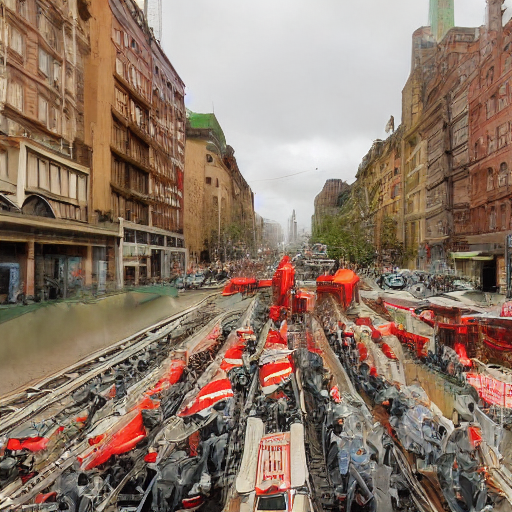

In [65]:
our[8][0]

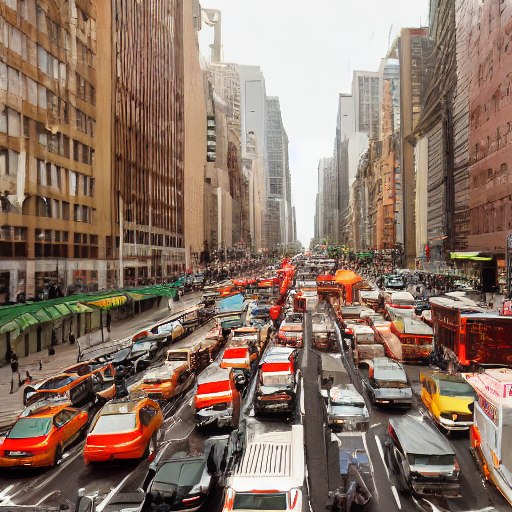

In [64]:
ground[8][0]

In [70]:
resnet50.eval().to("cuda:1")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [86]:
for i in range(10):
    ans = torch.argmax(resnet50(transform(our[i][0]).unsqueeze(0).to("cuda:1")), 1).item()
    # print(ans in car_indices)
    print(labels[ans])

taxicab
taxicab
tram
bubble
taxicab
taxicab
lifeboat
taxicab
taxicab
taxicab


In [87]:
for i in range(10):
    ans = torch.argmax(resnet50(transform(ground[i][0]).unsqueeze(0).to("cuda:1")), 1).item()
    # print(ans in car_indices)
    print(labels[ans])

taxicab
taxicab
tram
taxicab
taxicab
taxicab
taxicab
taxicab
taxicab
taxicab


In [ ]:
y

In [ ]:
z = detector.model.rgb(y)

In [ ]:
z.permute(0, 2, 3, 1)

In [ ]:
z

In [ ]:
mean_resnet = np.array([0.485, 0.456, 0.406])
std_resnet = np.array([0.229, 0.224, 0.225])
val_transform = T.Compose([T.Resize(224), T.Normalize(mean_resnet, std_resnet)])

def rgb(input):
    input = (input/2 + 0.5)
    MAX = torch.max(input).detach()
    MIN = torch.min(input.detach())
    input = (input - MIN) / (MAX - MIN)
    # input = input.permute(0, 2, 3, 1)
    # input = (input * 255).round().astype("uint8")
    tmp = torch.zeros((1, 512, 512, 3))
    tmp[0, :, :, 0] = input[0, 0, :, :]
    tmp[0, :, :, 1] = input[0, 1, :, :]
    tmp[0, :, :, 2] = input[0, 2, :, :]
    return val_transform(tmp[0]*255)

In [ ]:
z = rgb(y)

In [ ]:
x = latents_steps[0]
x = detector.model.vae.decode(1 / detector.model.vae.config.scaling_factor * x).sample

In [ ]:
x.shape

In [ ]:
img = detector.model.rgb(x)

In [ ]:
img.size()

In [ ]:
img = img.detach().cpu().numpy()

In [ ]:
img = (img * 255).round().astype("uint8")

In [ ]:
img[0].shape

In [ ]:
img = Image.fromarray(img[0])

In [ ]:
y = diffuser.to_image(x)

In [ ]:
y[0]

In [ ]:
MAX = torch.max(x)
MIN = torch.min(x)

In [ ]:
x = (x - MIN) / (MAX - MIN)

In [ ]:
def forward(input):
    input = (input/2 + 0.5)
    # MAX = torch.max(input.detach())
    # MIN = torch.min(input.detach())
    # input = (input - MIN) / (MAX - MIN)
    tmp = torch.zeros((1, 512, 512, 3))
    tmp[0, :, :, 0] = input[0, 0, :, :]
    tmp[0, :, :, 1] = input[0, 1, :, :]
    tmp[0, :, :, 2] = input[0, 2, :, :]    
    tmp = tmp.detach().cpu().numpy()
    tmp = (tmp * 255).round().astype("uint8")
    return tmp

In [ ]:
detector.model(forward(x))

In [ ]:
# x = diffuser.decode(x)
img = forward(x)

In [ ]:
img.shape

In [ ]:
out = Image.fromarray(img[0])

In [ ]:
out

In [ ]:
img[0]

In [ ]:
from torchvision.transforms import ToPILImage

In [ ]:
to_pil = ToPILImage()
pil_image = to_pil(x)

In [ ]:
pil_image

In [ ]:
x.shape

In [ ]:
img = detector.model.vae(x/detector.model.vae.config.scaling_factor).sample

detector.

In [ ]:
del diffuser, loss, optimizer, finetuner, negative_latents, latents_steps, latents

In [ ]:
# del diffuser, finetuner
diffuser = StableDiffuser(scheduler='DDIM').to('cuda:0').eval().half()

In [ ]:
finetuner = FineTunedModel.from_checkpoint(diffuser, "./experiment_car/car_checkpoint_40_20231205_222721.pt").eval().half()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
noise_level = 0
generator = torch.manual_seed(30)
with finetuner:
    finetuned_images = diffuser(
        "rush hour in new york city",
        n_steps=50,
        n_imgs=2,
        generator=generator,
        noise_level=noise_level,
    )

In [ ]:
finetuned_images[1][0]

In [ ]:
finetuned_images[9][0]

In [ ]:
finetuned_images[0][0]

In [ ]:
finetuned_images[1][0]

In [ ]:
finetuned_images[1][0]

In [ ]:
finetuned_images[4][0]

In [ ]:
resnet50.eval().to("cuda:1")

In [ ]:
predict = resnet50(transform(finetuned_images[0][0]).unsqueeze(0).cuda().to("cuda:1")).argmax()
labels[predict]

In [ ]:
input_image = transform(finetuned_images[1][0])
input_batch = input_image.unsqueeze(0)  # Add a batch dimension
output = resnet50(input_batch.to("cuda:1"))
compute_prob_from_output(output)

In [ ]:
car_train(
    prompt="rush hour in new york city", 
    modules = "unet$", 
    iterations=100, 
    negative_guidance=1, 
    lr=0.005,
    save_path="detector_car/test", 
    freeze_modules=[]
)

In [ ]:
del diffuser
del detector
del finetuner
# kwargs = dict(locals())
# print(f"train kwargs: {kwargs}")
print("BEGIN TRAIN")  
nsteps = 50
lr = 0.00001
prompt = "car"
diffuser = StableDiffuser(scheduler='DDIM').to('cuda:1')
diffuser.train()
detector = ObjectDetector()

modules = "unet$"
freeze_modules = []

finetuner = FineTunedModel(diffuser, modules, frozen_modules=freeze_modules)

optimizer = torch.optim.Adam(finetuner.parameters(), lr=lr)
criteria = torch.nn.MSELoss()
print("Begin pbar")

with torch.no_grad():
    neutral_text_embeddings = diffuser.get_text_embeddings([''],n_imgs=1)
    positive_text_embeddings = diffuser.get_text_embeddings([prompt],n_imgs=1)
del diffuser.vae
del diffuser.text_encoder
del diffuser.tokenizer
del diffuser.safety_checker    

In [ ]:
torch.cuda.empty_cache()

# generated_images = []

with torch.no_grad():
    diffuser.set_scheduler_timesteps(nsteps)

    optimizer.zero_grad()

    # diffuse_iter = torch.randint(1, nsteps-1, (1,)).item()
    # print(diffuse_iter)
    diffuse_iter = 49
    latents = diffuser.get_initial_latents(1, 512, 1)
    # print("LATENT SIZE: ", latents.size())
    with finetuner:
        latents_steps, _ = diffuser.diffusion(
            latents,
            positive_text_embeddings,
            start_iteration=0,
            end_iteration=diffuse_iter,
            guidance_scale=3,
            show_progress=False,
        )
    # diffuser.set_scheduler_timesteps(1000)
    # diffuse_iter = int(diffuse_iter / nsteps * 1000)
    neutral_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], neutral_text_embeddings, guidance_scale=1)

# with finetuner:
#     negative_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], positive_text_embeddings, guidance_scale=1)


In [ ]:
neutral_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], neutral_text_embeddings, guidance_scale=1)

In [ ]:
torch.norm(neutral_latents)

In [ ]:
detector.get_input_grad(latents_steps[-1])

In [ ]:
detector.get_input_grad(latents_steps[-1])

In [ ]:
decoded_step = detector.model.vae.decode(1 / detector.model.vae.config.scaling_factor * latents_steps[-1]).sample

In [ ]:
img = diffuser.to_image(decoded_step)

In [ ]:
img[0]

In [ ]:
decoded_step.shape

In [ ]:
output = d.model.classifier(decoded_step)

In [ ]:
# Get the predicted class
_, predicted_idx = torch.max(output, 1)
predicted_label = labels[predicted_idx.item()]

# Print the result
print(f'Predicted label: {predicted_label}')
print(f'Confidence: {_}')

In [ ]:
x = F.softmax(output, dim=1)
total_probability = 0
for i in car_indices:
    total_probability += x[0][i]
print(total_probability)

In [ ]:
d.get_input_grad(latents_steps[-1])

In [ ]:
d.model()

In [ ]:
from StableDiffuser import StableDiffuser
from finetuning import FineTunedModel
import torch
from tqdm import tqdm
import datetime
import torchvision
import torchvision.transforms as T
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from PIL import Image
from diffusers import AutoencoderKL
class RGBConverter(nn.Module):
    def __init__(self):
        super(RGBConverter, self).__init__()
        # Magic number used in the detector
        mean_resnet = np.array([0.485, 0.456, 0.406])
        std_resnet = np.array([0.229, 0.224, 0.225])
        self.val_transform = T.Compose([T.Resize(224), T.Normalize(mean_resnet, std_resnet)])
    
    def toRGB(self, RGBA, background=(255,255,255)):
        _, D, R, C = RGBA.shape
        if D == 3:
            return RGBA
        RGB = torch.zeros((1, 3, R, C), dtype=torch.float32)
        R, G, B, A = RGBA[0].split(1, dim=0)
        A = A.float() / 255
        RGB[0, 0,:,:] = R.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[0]
        RGB[0, 1,:,:] = G.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[1]
        RGB[0, 2,:,:] = B.squeeze() * A.squeeze() + (1 - A.squeeze()) * background[2]
        return RGB

    def forward(self, input):
        min = torch.min(input)
        max = torch.max(input)
        input = (input-min)/(max-min)*255
        #input = self.toRGB(input)
        input = self.val_transform(input.squeeze())
        return input

def create_model(num_artists):
    import torchvision
    # transfer learning on top of ResNet (only replacing final FC layer)
    # model_conv = torchvision.models.resnet18(pretrained=True)
    model_conv = torchvision.models.resnet18(pretrained=True)
    # Parameters of newly constructed modules have requires_grad=True by default
    for param in model_conv.parameters():
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_artists)
    # load the pre-trained weights
    model_conv.load_state_dict(torch.load('./detector/artist/artist_ckp/state_dict.dat.von_gogh'))
    
    return model_conv

class Model(nn.Module):
    def __init__(self, num_artists):
        super(Model, self).__init__()
        self.rgb = RGBConverter()
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to("cuda:1")
        self.model_conv = create_model(num_artists)

    def forward(self, x):
        x = self.vae.decode(1 / self.vae.config.scaling_factor * x).sample
        x = self.rgb(x)
        x = self.model_conv(x.unsqueeze(0))
        return x

class Detector():
    def __init__(self, device, num_artists=57):
        self.device = device
        self.dtype = torch.FloatTensor
        if (torch.cuda.is_available()):
            self.dtype = torch.cuda.FloatTensor
        # transfer learning on top of ResNet (only replacing final FC layer)
        self.model = Model(num_artists).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def get_input_grad(self, x, y): 
        x_var = Variable(x.type(self.dtype).to(self.device), requires_grad=True)
        loss_fn = nn.CrossEntropyLoss().type(self.dtype)
        y_var = Variable(y.type(self.dtype).long().to(self.device))
        scores = self.model(x_var)
        loss = loss_fn(scores, y_var)
        loss.backward()
        return x_var.grad

#num_artists = 53


def train(prompt, modules, finetune_iter, negative_guidance, lr, save_path, freeze_modules=[]):
    # kwargs = dict(locals())
    # print(f"train kwargs: {kwargs}")
    print("BEGIN TRAIN")  
    nsteps = 999

    diffuser = StableDiffuser(scheduler='DDIM').to('cuda:1')
    detector = Detector(num_artists=57, device='cuda:1')

    diffuser.train()

    finetuner = FineTunedModel(diffuser, modules, frozen_modules=freeze_modules)

    optimizer = torch.optim.Adam(finetuner.parameters(), lr=lr)
    criteria = torch.nn.MSELoss()

    print("Begin pbar")
    pbar = tqdm(range(finetune_iter))

    with torch.no_grad():
        neutral_text_embeddings = diffuser.get_text_embeddings([''],n_imgs=1)
        positive_text_embeddings = diffuser.get_text_embeddings([prompt],n_imgs=1)

    del diffuser.vae
    del diffuser.text_encoder
    del diffuser.tokenizer
    del diffuser.safety_checker

    torch.cuda.empty_cache()

    generated_images = []
    for i in pbar:
        with torch.no_grad():
            diffuser.set_scheduler_timesteps(nsteps)

            optimizer.zero_grad()

            diffuse_iter = 40  #torch.randint(1, nsteps - 1, (1,)).item()

            latents = diffuser.get_initial_latents(1, 512, 1)
            # print("LATENT SIZE: ", latents.size())
            with finetuner:
                latents_steps, _ = diffuser.diffusion(
                    latents,
                    positive_text_embeddings,
                    start_iteration=0,
                    end_iteration=diffuse_iter,
                    guidance_scale=3,
                    show_progress=False
                )
            
            diffuser.set_scheduler_timesteps(1000)
            diffuse_iter = int(diffuse_iter / nsteps * 1000)
            #neutral_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], neutral_text_embeddings, guidance_scale=1)

        with finetuner:
            negative_latents = diffuser.predict_noise(diffuse_iter, latents_steps[0], positive_text_embeddings, guidance_scale=1)
        
        y = torch.tensor([4]) # label of Von Gogh
        input_x = latents_steps[0]
        # dump input_x to a file
        torch.save(input_x, "detector/artist/test_vg/input_{}.pt".format(i))
        generated_images.append(input_x)
        detector_grad = detector.get_input_grad(input_x, y)

        loss = criteria(negative_latents, negative_latents - (negative_guidance*detector_grad)) #loss = criteria(e_n, e_0) works the best try 5000 epochs
        
        loss.backward()
        optimizer.step()

        # TODO: (Hack @Mike) Checkpoint every 20 epochs.
        if i % 50 == 0 and i != 0:
            now_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            torch.save(
                finetuner.state_dict(), 
                save_path + f'_checkpoint_{i}_{now_str}.pt'
            )
    
    now_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(finetuner.state_dict(), save_path + f'_{now_str}.pt')

    del diffuser, loss, optimizer, finetuner, negative_latents, neutral_latents, latents_steps, latents

    torch.cuda.empty_cache()

train(
    prompt="von gogh", 
    modules = "unet$", 
    finetune_iter=100, 
    negative_guidance=1, 
    lr=0.00001, 
    save_path="lily_model_ckp/classifier/finetuned_vangogh", 
    freeze_modules=[]
)

In [ ]:
[0, 2, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 29]